# Environmental Sound Classification (UrbanSound8K dataset)

## Goal
Build RNN and Transformer model that can identify 10 types of urban sounds from UrbanSound8K dataset. 

## 0. Imports

In [1]:
!pip install soundata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 21.4 MB/s eta 0:00:00


In [2]:
import soundata
import numpy as np
import torchaudio
import torch
from tqdm import tqdm
import librosa
from IPython.display import Audio, display, HTML
import numpy as np
import random
from termcolor import colored
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## 1. Data preparation

### 1.1 Creating Feature Space

In [3]:
class DataLoader:
    def __init__(self,config):
        self.config = config
        self.dataset = None
        self.clips = None 
        self.feature_data = {
            'train': {'features':[],'labels':[],'folds':[]},
            'val':{'features':[],'labels':[],'folds':[]},
            'test':{'features':[],'labels':[],'folds':[]}
        }

    def download_and_validate(self):
        print("Initializing dataset")
        self.dataset = soundata.initialize('urbansound8k')

        try:
            # in case it is already downloaded
            print("Validating dataset")
            self.dataset.validate()
        except Exception as e:
            print("Downloading dataset")
            self.dataset.download()

        self.clips = self.dataset.load_clips()
        print(f"Loaded {len(self.clips)} audio clips")

    def get_fold_number(self,clip_id):
        clip = self.clips[clip_id]
        if hasattr(clip, '_clip_metadata'):
            metadata = clip._clip_metadata
            if isinstance(metadata, dict) and 'fold' in metadata:
                return int(metadata['fold'])
                
    def preprocess_audio(self, audio, original):
        # 1. resample audio to standardize inputs ensuring all audio files have same sample rate for consistent processing
        if original != self.config['sample_rate']:
            # initialize pytorch resampler with original and target sample rates
            resampler = torchaudio.transforms.Resample(
                orig_freq=original,                     # original sample rate
                new_freq=self.config['sample_rate']     # target sample rate
            )

            audio = resampler(torch.tensor(audio).float()).numpy()
        
        # 2. channel normalization 
        # converting to mono if multi channel so it could train faster and it is better for sound recognition
        if audio.ndim > 1:
            audio = librosa.to_mono(audio)
        # 3. duration standarization
        # target length = duration * sample rate
        target_samples = int(self.config['max_duration'] * self.config['sample_rate'])
        
        # case1: audio is shorter than target duration
        if len(audio) < target_samples:
            # calculate padding needed (only at end of audio)
            pad_amount = target_samples - len(audio)
            # add zero padding (silence) at the end
            audio = np.pad(audio, (0, pad_amount))
        
        # case2: audio is longer than target duration
        else:
            # truncate to the target length (keep beginning portion)
            audio = audio[:target_samples]
        return audio
    
    def extract_features(self,audio):
        # mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,  
            sr=self.config['sample_rate'], 
            n_fft=self.config['n_fft'],  
            hop_length=self.config['hop_length'],  
            n_mels=self.config['n_mels']  
        )
        # convert power spectrogram to dB scale (log transform) which matches human hearing's perception
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)

        # RMS -> per frame loudness estimate
        energy = librosa.feature.rms(
            y=audio,
            frame_length=self.config['n_fft'],  
            hop_length=self.config['hop_length']
        )

        # MFCCs -> Mel Frequency Cepstral Coefficients
        # compact spectral representation
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=self.config['sample_rate'],
            n_mfcc=self.config['n_mfcc'],  
            n_fft=self.config['n_fft'],
            hop_length=self.config['hop_length']
        )
        return {
            'waveform': audio,  
            'log_mel': log_mel,
            'energy': energy,  
            'mfcc': mfcc  
        }
    def process_dataset(self):
        print("Processing dataset")
        for clip_id, clip in tqdm(self.clips.items()):
            audio, sr = clip.audio
            fold = self.get_fold_number(clip_id)
            class_name = clip.tags.labels[0]
            
            audio = self.preprocess_audio(audio, sr)
            features = self.extract_features(audio)
            
            split = self.get_split(fold)
            if split:
                self.feature_data[split]['features'].append(features)
                self.feature_data[split]['labels'].append(class_name)
                self.feature_data[split]['folds'].append(fold)

    def get_split(self, fold):
        if fold in self.config['train_folds']:
            return 'train'
        elif fold in self.config['val_folds']:
            return 'val'
        elif fold in self.config['test_folds']:
            return 'test'
        return None
    
    def get_processed_data(self):
        return {
            'train': {
                'features': np.array(self.feature_data['train']['features']),
                'labels': np.array(self.feature_data['train']['labels']),
                'folds': np.array(self.feature_data['train']['folds'])
            },
            'val': {
                'features': np.array(self.feature_data['val']['features']),
                'labels': np.array(self.feature_data['val']['labels']),
                'folds': np.array(self.feature_data['val']['folds'])
            },
            'test': {
                'features': np.array(self.feature_data['test']['features']),
                'labels': np.array(self.feature_data['test']['labels']),
                'folds': np.array(self.feature_data['test']['folds'])
            }
        }


In [4]:
config = {
    'sample_rate': 16000,
    'max_duration': 4.0,
    'n_fft': 2048,
    'hop_length': 512,
    'n_mels': 64,
    'n_mfcc': 20,
    'train_folds': list(range(1, 7)),
    'val_folds': [7, 8],
    'test_folds': [9, 10],
    'resample': True
}

data_loader = DataLoader(config)
data_loader.download_and_validate()
data_loader.process_dataset()

Initializing dataset
Validating dataset


5.61GB [04:45, 21.1MB/s]                                
1.15MB [00:01, 879kB/s]                             


Loaded 8732 audio clips
Processing dataset


100%|██████████| 8732/8732 [03:41<00:00, 39.43it/s]


In [5]:
processed_data = data_loader.get_processed_data()

# training data
train_features = processed_data['train']['features']
train_labels = processed_data['train']['labels']
train_folds = processed_data['train']['folds']

# validation data
val_features = processed_data['val']['features']
val_labels = processed_data['val']['labels']
val_folds = processed_data['val']['folds']

# test data
test_features = processed_data['test']['features']
test_labels = processed_data['test']['labels']
test_folds = processed_data['test']['folds']

In [6]:
# dataset statistics
print("\nDataset statistics:")
print(f"Training set: {len(train_features)} samples")
print(f"Validation set: {len(val_features)} samples")
print(f"Test set: {len(test_features)} samples")

# sample shapes
print("\nFeature Shapes (first sample):")
print(f"Waveform: {train_features[0]['waveform'].shape}")
print(f"Log Mel: {train_features[0]['log_mel'].shape}")
print(f"MFCCs: {train_features[0]['mfcc'].shape}")
print(f"Energy: {train_features[0]['energy'].shape}")

# class distribution in each set 
print("\nClass distribution:")
print(f"Training classes: {np.unique(train_labels)}")
print(f"Validation classes: {np.unique(val_labels)}")
print(f"Test classes: {np.unique(test_labels)}")

# fold distribution
print("\nFold distribution:")
print(f"Training folds: {np.unique(train_folds)}")
print(f"Validation folds: {np.unique(val_folds)}")
print(f"Test folds: {np.unique(test_folds)}")


Dataset statistics:
Training set: 5435 samples
Validation set: 1644 samples
Test set: 1653 samples

Feature Shapes (first sample):
Waveform: (64000,)
Log Mel: (64, 126)
MFCCs: (20, 126)
Energy: (1, 126)

Class distribution:
Training classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
Validation classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
Test classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']

Fold distribution:
Training folds: [1 2 3 4 5 6]
Validation folds: [7 8]
Test folds: [ 9 10]


## 1.2 Visualizations and Analysis

In [7]:
# helper functions
def class_palette(labels):
    classes = sorted(np.unique(labels).tolist())
    class_palette = sns.color_palette("husl", len(classes))
    return dict(zip(classes, class_palette))

def plot_class_distribution(labels, title, ax=None, color_dict=None):
    if ax is None:
        _,ax = plt.subplots(figsize=(12,6))

    class_counts = Counter(labels)
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]
    if color_dict is None:
        color_dict = class_palette(labels)
    colors = [color_dict[c] for c in classes]

    # bar plots 
    sns.barplot(x=classes,y=counts,ax=ax,palette=colors,hue=classes,legend=False,dodge=False)
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # count labels 
    for i,p in enumerate(ax.patches):
        ax.annotate(f'{counts[i]}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', 
            xytext=(0, 7), 
            textcoords='offset points',
            fontsize=9)

### 1.2.1 Playing Samples

In [8]:
def play_audio(features_list, labels, sample_rate, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    classes = np.unique(labels)
    print(colored("\nCLASS AUDIO EXAMPLES", "blue", attrs=["bold", "underline"]))
    for c in classes:
        classes_indices = np.where(labels == c)[0]
        i = random.choice(classes_indices)
        waveform = features_list[i]['waveform']
        class_header = colored(f"   Class: {c}","magenta", attrs=["bold"])
        sample_info = colored(f" (Sample {i})","green")
        print(f"{class_header}{sample_info}")
        display(Audio(data=waveform,rate=sample_rate))



In [9]:
play_audio(features_list=train_features,labels=train_labels,sample_rate=config['sample_rate'],seed=42)


CLASS AUDIO EXAMPLES
   Class: air_conditioner (Sample 1009)


   Class: car_horn (Sample 472)


   Class: children_playing (Sample 2502)


   Class: dog_bark (Sample 2292)


   Class: drilling (Sample 1924)


   Class: engine_idling (Sample 1475)


   Class: gun_shot (Sample 4673)


   Class: jackhammer (Sample 737)


   Class: siren (Sample 4756)


   Class: street_music (Sample 795)


### 1.2.2 Dataset Statistics

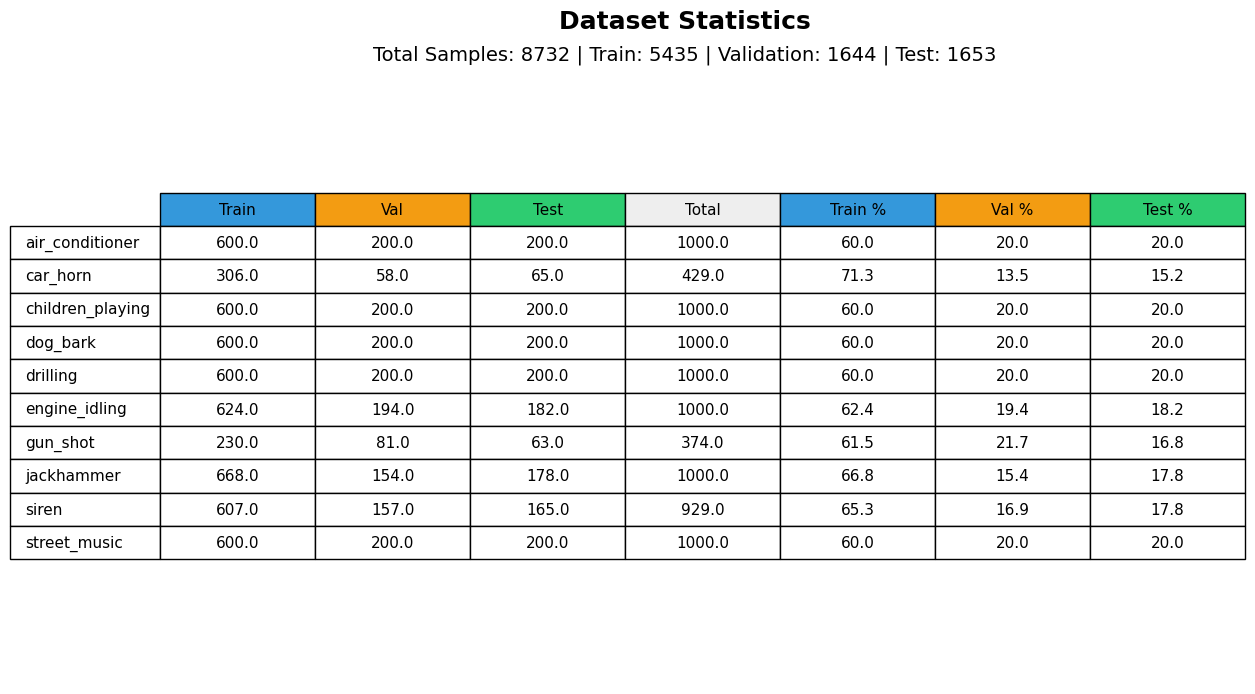

In [10]:
all_labels = np.concatenate([train_labels, val_labels, test_labels])
unique_labels = sorted(np.unique(all_labels).tolist())
stats_data = []
for i in unique_labels:
    stats_data.append([np.sum(train_labels==i),np.sum(val_labels==i),np.sum(test_labels==i),np.sum(all_labels == i)])

stats_df = pd.DataFrame(stats_data, index=unique_labels,columns=['Train', 'Validation', 'Test', 'Total'])

stats_df['Train %'] = (stats_df['Train'] / stats_df['Total'] * 100).round(1)
stats_df['Val %'] = (stats_df['Validation'] / stats_df['Total'] * 100).round(1)
stats_df['Test %'] = (stats_df['Test'] / stats_df['Total'] * 100).round(1)

plt.figure(figsize=(14, 8))
ax = plt.gca()
ax.axis('off')
table = plt.table(
    cellText=stats_df.values,
    rowLabels=stats_df.index,
    colLabels=['Train', 'Val', 'Test', 'Total', 'Train %', 'Val %', 'Test %'],
    cellLoc='center',
    loc='center',
    colColours=['#3498db', '#f39c12', '#2ecc71', '#eeeeee', '#3498db', '#f39c12', '#2ecc71']
)

table.set_fontsize(11)
table.scale(1,2)
plt.figtext(0.5, 0.93, 'Dataset Statistics', ha='center', fontsize=18, weight='bold')
plt.figtext(0.5, 0.89, f"Total Samples: {len(all_labels)} | "
                      f"Train: {len(train_labels)} | "
                      f"Validation: {len(val_labels)} | "
                      f"Test: {len(test_labels)}", 
           ha='center', fontsize=14)

plt.show()

### 1.2.3 Class Distribution Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


AttributeError: Rectangle.set() got an unexpected keyword argument 'legend'

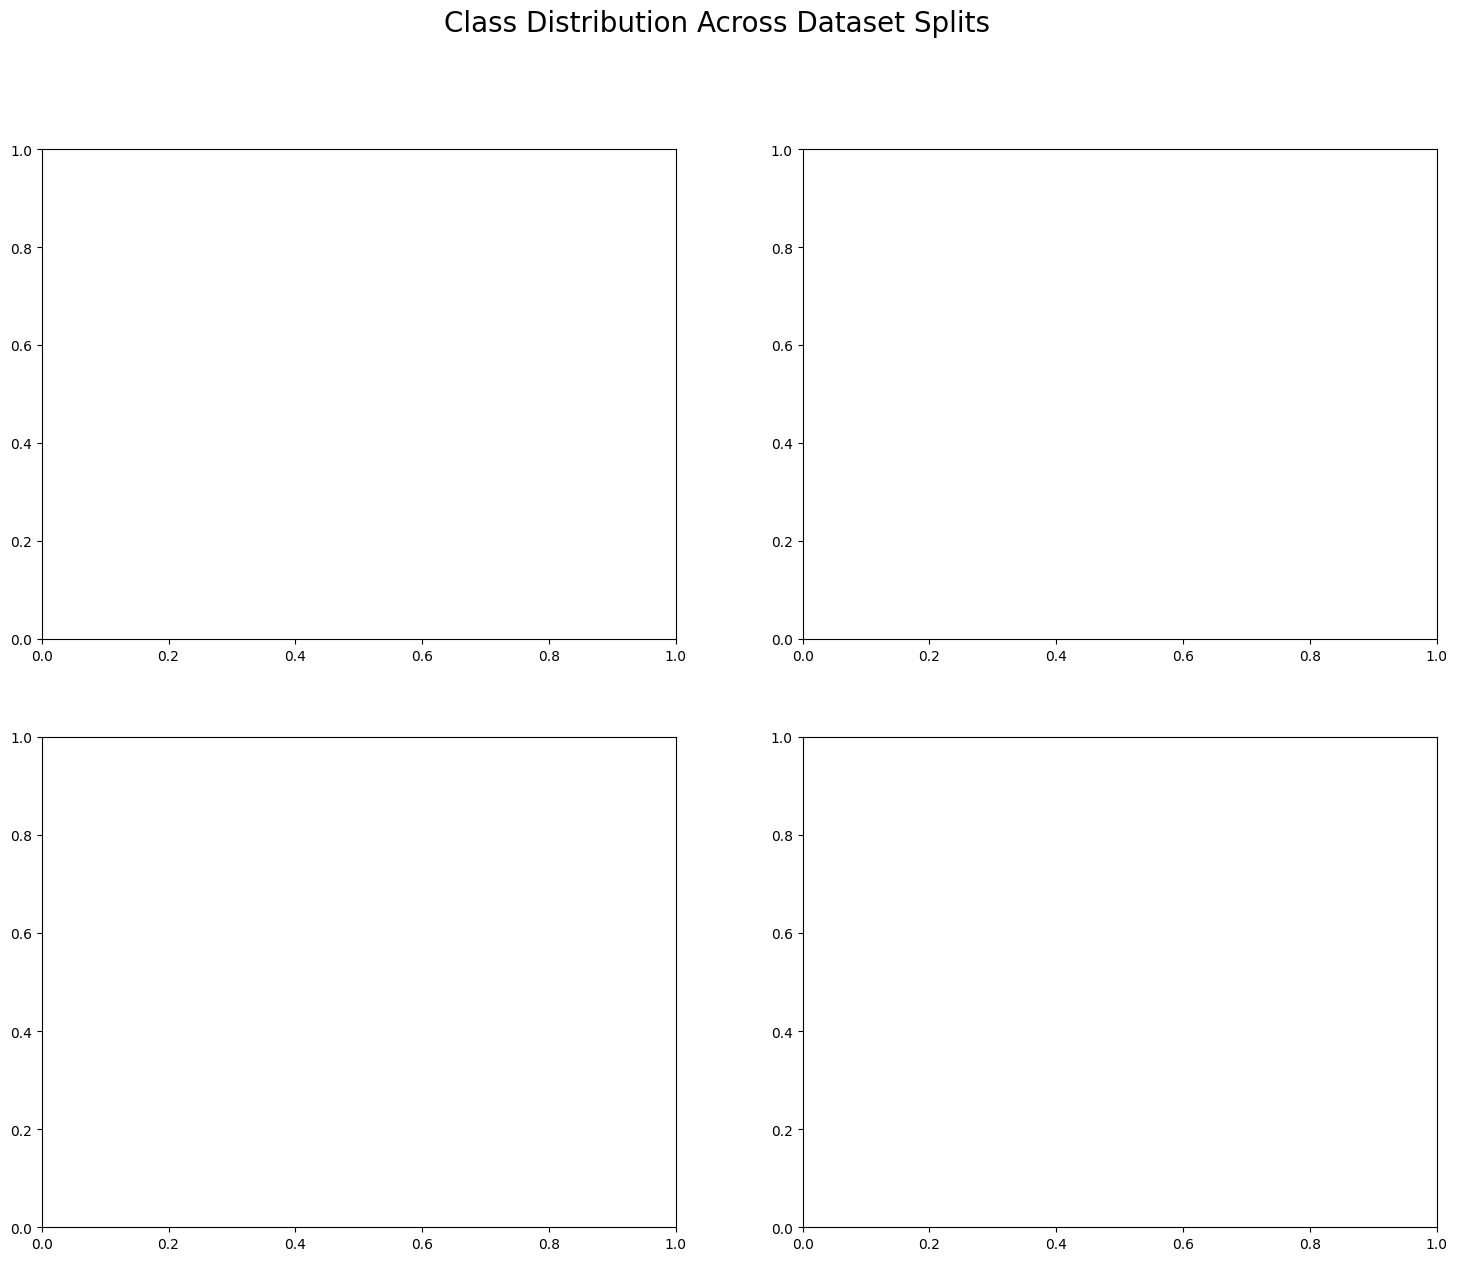

In [12]:
all_labels = np.concatenate([train_labels, val_labels, test_labels])
fig1, axs1 = plt.subplots(2, 2, figsize=(18, 14))
fig1.suptitle('Class Distribution Across Dataset Splits', fontsize=20, y=0.98)

plot_class_distribution(labels=train_labels, 
                       title='Training Set', 
                       ax=axs1[0, 0])

plot_class_distribution(labels=val_labels, 
                       title='Validation Set', 
                       ax=axs1[0, 1])

plot_class_distribution(labels=test_labels, 
                       title='Test Set', 
                       ax=axs1[1, 0])

plot_class_distribution(labels=all_labels, 
                       title='Overall Dataset', 
                       ax=axs1[1, 1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 1.2.4 Waveform & Spectrogram Plots

In [13]:
def plot_waveform(audio,sample_rate,title="Waveform",ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,3))

    time = np.linspace(0,len(audio)/sample_rate,len(audio))
    ax.plot(time,audio)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("Amplitude",fontsize=10)
    ax.set_xlim(0, time[-1])
    ax.grid(alpha=0.3)
    return ax

def plot_mel_spectrogram(log_mel,sample_rate,hop_length,title="Mel Spectrogram",ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,4))
    else:
        fig = ax.figure

    img = librosa.display.specshow(log_mel, sr=sample_rate,hop_length=hop_length,x_axis='time',y_axis='mel',ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("Frequency (Hz)",fontsize=10)
    fig.colorbar(img,ax=ax,format="%+2.0f dB")
    return ax

def plot_energy(energy,sample_rate,hop_length,title="Energy (RMS)",ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))
    times = librosa.times_like(energy,sr=sample_rate,hop_length=hop_length)
    ax.plot(times, energy.flatten(),color='r',linewidth=1.5)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("Energy",fontsize=10)
    ax.set_xlim(0, times[-1])
    ax.grid(alpha=0.3)
    return ax

def plot_mfcc(mfcc,sample_rate,hop_length,title="MFCCs",ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        fig = ax.figure
    
    img = librosa.display.specshow(mfcc,sr=sample_rate,hop_length=hop_length,x_axis='time',ax=ax,cmap='coolwarm')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)",fontsize=10)
    ax.set_ylabel("MFCC Coefficients",fontsize=10)
    fig.colorbar(img, ax=ax)
    return ax

def plot_all(feature_dict,sample_rate,hop_length,class_name=""):
    fig,axs = plt.subplots(4,1,figsize=(12,10),sharex=True)
    fig.suptitle(f"{class_name}",fontsize=16,y=0.98)

    plot_waveform(feature_dict['waveform'], sample_rate, title="Waveform", ax=axs[0])
    plot_mel_spectrogram(feature_dict['log_mel'], sample_rate, hop_length, title="Mel Spectrogram", ax=axs[1])
    plot_energy(feature_dict['energy'], sample_rate, hop_length, title="Energy (RMS)", ax=axs[2])
    plot_mfcc(feature_dict['mfcc'], sample_rate, hop_length, title="MFCCs", ax=axs[3])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    return fig

def plot_classes(features_list,labels,sample_rate,hop_length,n_classes=5):
    classes = np.unique(labels)[:n_classes]
    fig, axs = plt.subplots(n_classes,4,figsize=(16,3*n_classes))
    fig.suptitle("Classes Feature Analysis",fontsize=20,y=0.98)
    
    for i, c in enumerate(classes):
        idx = np.where(labels == c)[0][0]
        features = features_list[idx]
        plot_waveform(features['waveform'], sample_rate, f"{c} Waveform", ax=axs[i, 0])
        plot_mel_spectrogram(features['log_mel'], sample_rate, hop_length, f"{c} Mel Spectrogram", ax=axs[i, 1])
        plot_energy(features['energy'], sample_rate, hop_length, f"{c} Energy", ax=axs[i, 2])
        plot_mfcc(features['mfcc'], sample_rate, hop_length, f"{c} MFCCs", ax=axs[i, 3])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    return fig

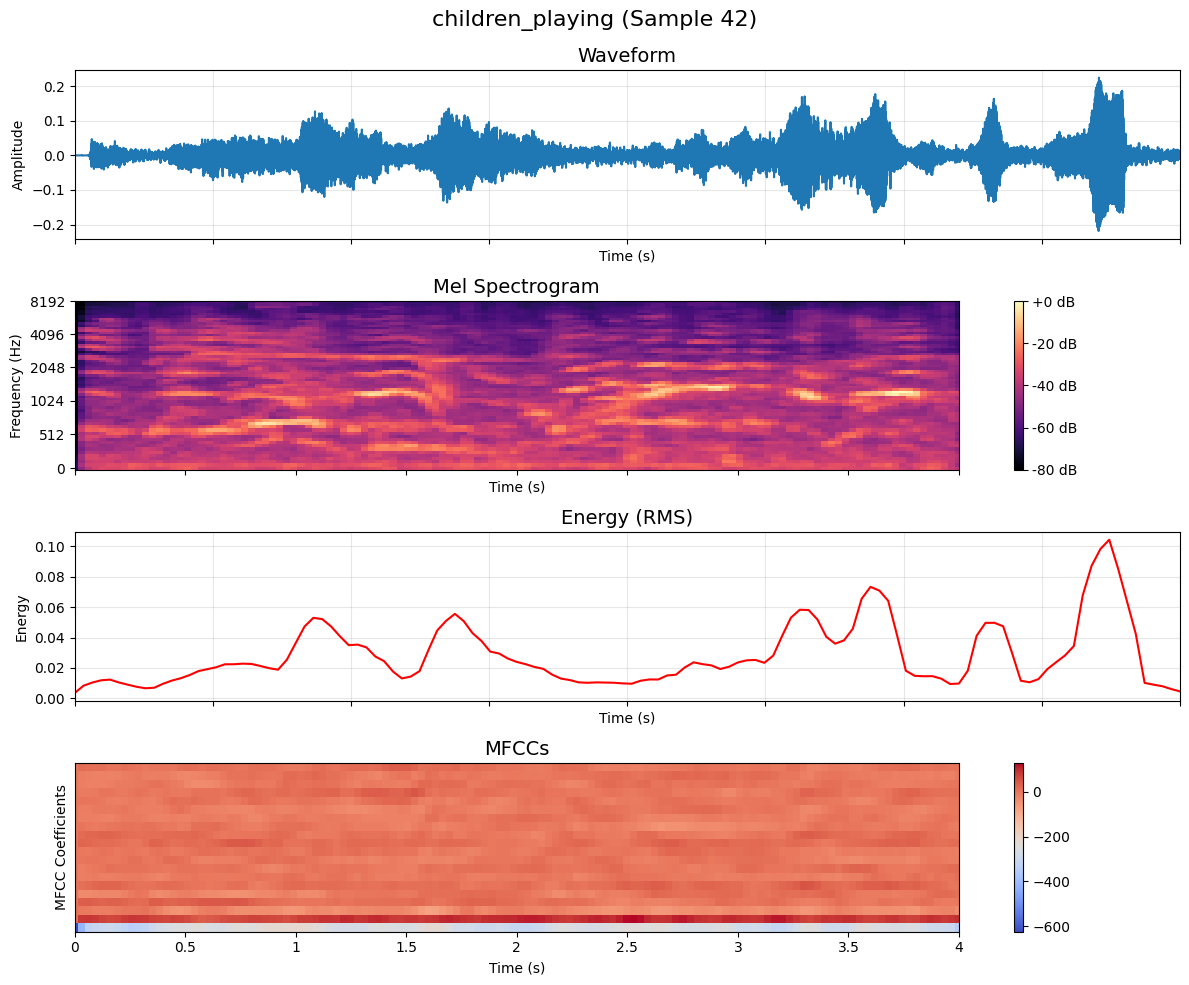

In [15]:
sample = 42
features = train_features[sample]
class_name = train_labels[sample]

plot_all(features,sample_rate=config['sample_rate'],hop_length=config['hop_length'],class_name=f"{class_name} (Sample {sample})")
plt.show()

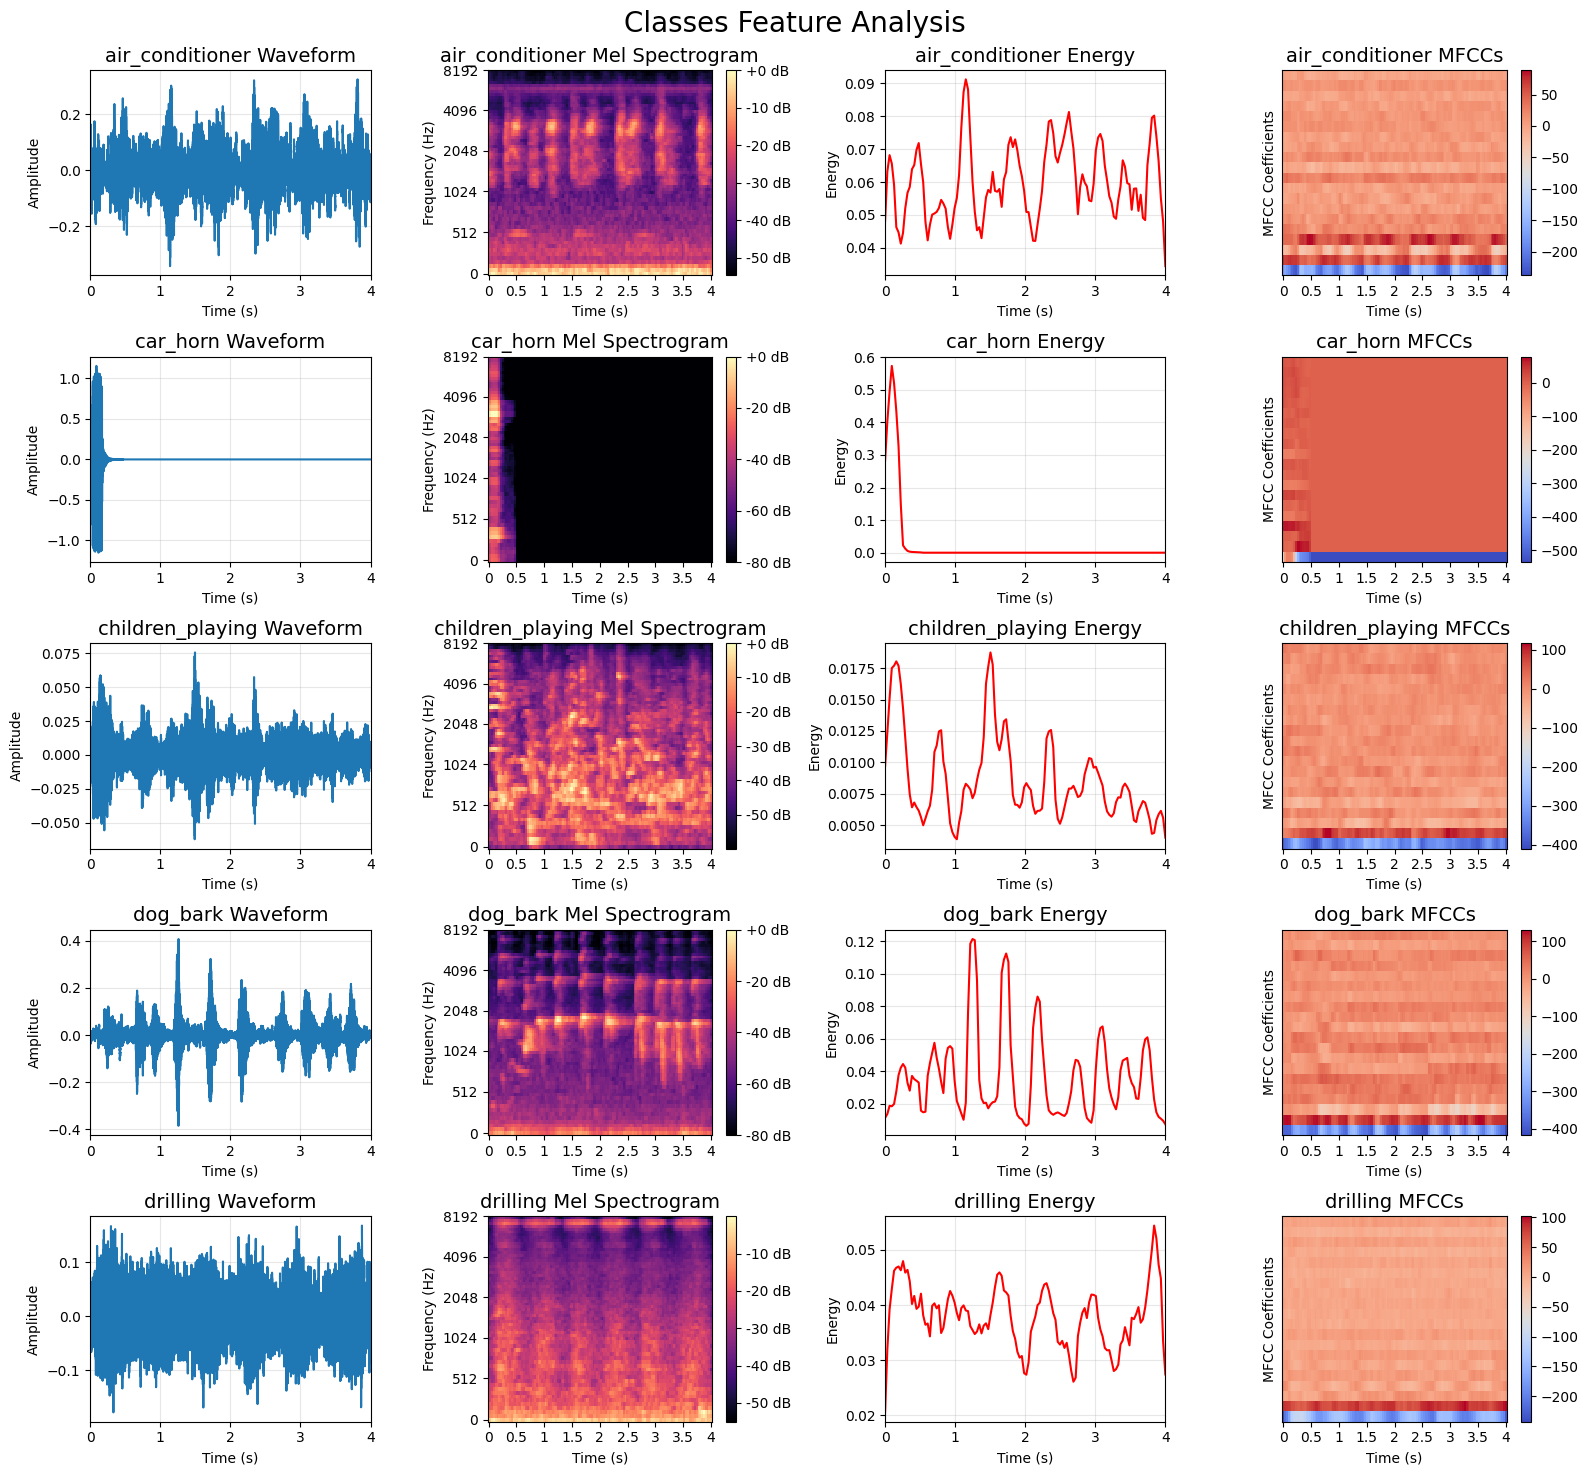

In [16]:
plot_classes(
    features_list=train_features,
    labels=train_labels,
    sample_rate=config['sample_rate'],
    hop_length=config['hop_length'],
    n_classes=5
)
plt.show()

## 2. Building the Model

### 2.1 RNN Model

### 2.2 Transformer Model

In [36]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float, seq_len: int = 5000):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) #unsqueeze for broadcasting
        div_term = 10000.0 ** (torch.arange(2, d_model + 2, 2).float() / (d_model))
        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)
        pe = pe.unsqueeze(0)  # (1, seq_len, d_model) we do that for broadcasting
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + (self.pe[:, : x.shape[1], :]).requires_grad_(False) # positional embedding is fixed no gradient required
        return self.dropout(x)


class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return (x - mean) / (std + self.eps)


class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)  # W1 and B1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)  # W2 and B2

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model, bias=False) 
        self.w_k = nn.Linear(d_model, d_model, bias=False) 
        self.w_v = nn.Linear(d_model, d_model, bias=False) 
        self.w_o = nn.Linear(d_model, d_model, bias=False) 

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, dropout: nn.Dropout):
        d_k = query.shape[-1]

        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value)

    def forward(self, q, k, v):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # query, key, value: [batch_size, num_heads, seq_len, d_k]
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x = MultiHeadAttentionBlock.attention(
            query, key, value, self.dropout
        )

        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k) # x: [batch_size, seq_len, d_k * num_heads]
        return self.w_o(x)


class ResidualConnection(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(self.norm(sublayer(x)))


class EncoderBlock(nn.Module):
    def __init__(
        self,
        self_attention_block: MultiHeadAttentionBlock,
        feed_froward_block: FeedForwardBlock,
        dropout: float,
    ):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_froward_block
        self.residual_connection = nn.ModuleList(
            [ResidualConnection(dropout) for _ in range(2)]
        )

    def forward(self, x):
        x = self.residual_connection[0](
            x, lambda x: self.self_attention_block(x, x, x)
        )
        x = self.residual_connection[1](x, self.feed_forward_block)
        return x


class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)


## 3. Comparison

In [37]:
import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(
        self, input_dim, model_dim, num_classes, num_heads=4, num_layers=2, dropout=0.1, d_ff = 2048
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, dropout=dropout)

        encoder_blocks = []
        for _ in range(num_layers):
            encoder_self_attention_block = MultiHeadAttentionBlock(
                model_dim, num_heads, dropout
            )
            fead_forward_block = FeedForwardBlock(model_dim, d_ff, dropout=dropout)
            encoder_block = EncoderBlock(
                encoder_self_attention_block, fead_forward_block, dropout
            )
            encoder_blocks.append(encoder_block)
        self.encoder = Encoder(nn.ModuleList(encoder_blocks))

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        x = self.input_proj(x)  # [B, T, D]
        x = self.pos_encoder(x)  # [B, T, D]
        x = self.encoder(x)  # [B, T, D]
        x = x.transpose(1, 2)  # [B, D, T]
        x = self.pool(x).squeeze(-1)  # [B, D]
        return self.classifier(x)  # [B, num_classes]

In [19]:
label_to_index = {
    'air_conditioner': 0,
    'car_horn': 1,
    'children_playing': 2,
    'dog_bark': 3,
    'drilling': 4,
    'engine_idling': 5,
    'gun_shot': 6,
    'jackhammer': 7,
    'siren': 8,
    'street_music': 9
}

class DataFeatureSplitter():
    def __init__(self, data, labels, label_to_index):
        self.data = data
        self.labels = labels
        self._convert_labels_to_index(label_to_index)

    def feature_splitter(self, feature_name):
        n = len(self.data)
        X, y = [], []
        for i in range(n):
            X.append(self.data[i][feature_name])
            y.append(self.labels[i])
        return np.array(X), np.array(y)

    def _convert_labels_to_index(self, label_to_index):
        index_labels = []
        for i in range(len(self.labels)):
            index_labels.append(label_to_index[self.labels[i]])
        self.labels = np.array(index_labels)

train_splitter = DataFeatureSplitter(train_features, train_labels, label_to_index)
X_train_mfcc, y_train_mfcc = train_splitter.feature_splitter('mfcc')
X_train_log_mel, y_train_log_mel = train_splitter.feature_splitter('log_mel')
X_train_energy, y_train_energy = train_splitter.feature_splitter('energy')

val_splitter = DataFeatureSplitter(val_features, val_labels, label_to_index)
X_val_mfcc, y_val_mfcc = val_splitter.feature_splitter('mfcc')
X_val_log_mel, y_val_log_mel = val_splitter.feature_splitter('log_mel')
X_val_energy, y_val_energy = val_splitter.feature_splitter('energy')

test_splitter = DataFeatureSplitter(test_features, test_labels, label_to_index)
X_test_mfcc, y_test_mfcc = test_splitter.feature_splitter('mfcc')
X_test_log_mel, y_test_log_mel = test_splitter.feature_splitter('log_mel')
X_test_energy, y_test_energy = test_splitter.feature_splitter('energy')

In [20]:
X_train_mfcc = np.transpose(X_train_mfcc, (0, 2, 1))
X_val_mfcc = np.transpose(X_val_mfcc, (0, 2, 1))
X_test_mfcc = np.transpose(X_test_mfcc, (0, 2, 1))

X_train_log_mel = np.transpose(X_train_log_mel, (0, 2, 1))
X_val_log_mel = np.transpose(X_val_log_mel, (0, 2, 1))
X_test_log_mel = np.transpose(X_test_log_mel, (0, 2, 1))

X_train_energy = np.transpose(X_train_energy, (0, 2, 1))
X_val_energy = np.transpose(X_val_energy, (0, 2, 1))
X_test_energy = np.transpose(X_test_energy, (0, 2, 1))

In [21]:
from torch.utils.data import Dataset, DataLoader

class SoundDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, loader, optimizer, criterion):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for X, y in loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

        return running_loss / total, correct / total

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = outputs.max(1)

            correct += predicted.eq(y).sum().item()
            total += y.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    accuracy = correct / total
    return accuracy, all_preds, all_labels

In [40]:
import torch.nn as nn
import torch.optim as optim
from itertools import product

num_epochs = 50

hyperparameter_space = {
    "learning_rate": [1e-3],
    "dropout": [0.3, 0.1],
    "number_of_heads": [4, 8],
    "number_of_layers": [3, 6],
    "d_ff":[2048],
    'model_dim': [128, 256]
}

keys = list(hyperparameter_space.keys())
values = list(hyperparameter_space.values())


feature_sets = {
    "mfcc": {
        "train": (X_train_mfcc, y_train_mfcc),
        "val": (X_val_mfcc, y_val_mfcc),
        "test": (X_test_mfcc, y_test_mfcc),
        "feature_dim": 20,
    },
    "energy": {
        "train": (X_train_energy, y_train_energy),
        "val": (X_val_energy, y_val_energy),
        "test": (X_test_energy, y_test_energy),
        "feature_dim": 1,
    },
    "log_mel": {
        "train": (X_train_log_mel, y_train_log_mel),
        "val": (X_val_log_mel, y_val_log_mel),
        "test": (X_test_log_mel, y_test_log_mel),
        "feature_dim": 64,
    },
}

results = {
    "mfcc": {"best_model": None, "best_val_acc": 0, "best_config": None, "test_loader": None},
    "energy": {"best_model": None, "best_val_acc": 0, "best_config": None, "test_loader": None},
    "log_mel": {"best_model": None, "best_val_acc": 0, "best_config": None, "test_loader": None},
}


for feature_name, splits in feature_sets.items():
    print(f"\n=== Using feature set: {feature_name.upper()} ===")
    print(
        f"{'Trial':<5} {'LR':<8} {'Dropout':<8} {'Heads':<6} {'Layers':<7} {'TrainLoss':<10} {'TrainAcc':<10} {'ValAcc':<10}"
    )
    print("-" * 70)

    X_train, y_train = splits["train"]
    X_val, y_val = splits["val"]
    X_test, y_test = splits["test"]

    feature_dim = splits["feature_dim"]
    train_dataset = SoundDataset(X_train, y_train)
    val_dataset = SoundDataset(X_val, y_val)
    test_dataset = SoundDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)
    results[feature_name]['test_loader'] = test_loader

    for i, combo in enumerate(product(*values)):
        config = dict(zip(keys, combo))
        model = TransformerClassifier(
            input_dim=feature_dim,
            model_dim=config['model_dim'],
            num_classes=10,
            num_heads=config["number_of_heads"],
            num_layers=config["number_of_layers"],
            dropout=config["dropout"],
            d_ff=config['d_ff']
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

        for epoch in range(num_epochs):
            train_loss, train_acc = train(model, train_loader, optimizer, criterion)
            val_acc, _, _ = evaluate(model, val_loader)

        if val_acc > results[feature_name]["best_val_acc"]:
            results[feature_name]["best_model"] = model
            results[feature_name]["best_val_acc"] = val_acc
            results[feature_name]["best_config"] = config
        print(
            f"{i+1:<5} {config['learning_rate']:<8} {config['dropout']:<8} {config['number_of_heads']:<6} {config['number_of_layers']:<7} {train_loss:<10.4f} {train_acc:<10.4f} {val_acc:<10.4f}"
        )


=== Using feature set: MFCC ===
Trial LR       Dropout  Heads  Layers  TrainLoss  TrainAcc   ValAcc    
----------------------------------------------------------------------
1     0.001    0.3      4      3       0.0504     0.9868     0.6490    
2     0.001    0.3      4      3       0.1349     0.9678     0.6022    
3     0.001    0.3      4      6       0.0733     0.9844     0.6417    
4     0.001    0.3      4      6       0.2325     0.9349     0.6186    
5     0.001    0.3      8      3       0.0654     0.9842     0.6083    
6     0.001    0.3      8      3       0.0944     0.9790     0.5754    
7     0.001    0.3      8      6       0.0525     0.9906     0.5876    
8     0.001    0.3      8      6       0.1441     0.9628     0.6156    
9     0.001    0.1      4      3       0.0730     0.9785     0.6332    
10    0.001    0.1      4      3       0.0292     0.9945     0.5931    
11    0.001    0.1      4      6       0.0229     0.9958     0.6180    
12    0.001    0.1      4      6

KeyboardInterrupt: 


FINAL TEST RESULTS FOR EACH FEATURE SET

Feature Set: MFCC
Test Accuracy: 0.6195
F1 Score (macro): 0.6355
Best Hyperparameter Configuration:
learning_rate       : 0.001
dropout             : 0.3
number_of_heads     : 16
number_of_layers    : 6
d_ff                : 4096
model_dim           : 64


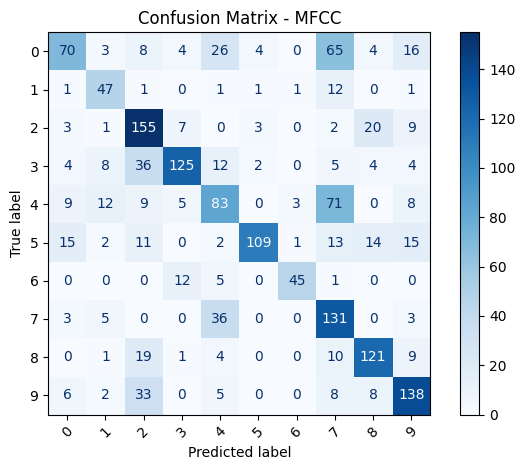


Feature Set: ENERGY
Test Accuracy: 0.2377
F1 Score (macro): 0.2077
Best Hyperparameter Configuration:
learning_rate       : 0.001
dropout             : 0.3
number_of_heads     : 16
number_of_layers    : 6
d_ff                : 4096
model_dim           : 64


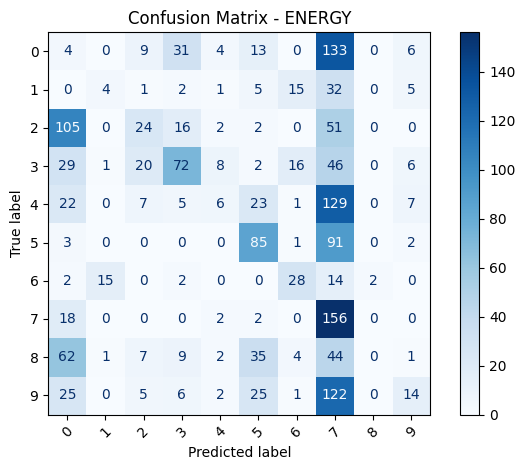


Feature Set: LOG_MEL
Test Accuracy: 0.6158
F1 Score (macro): 0.6215
Best Hyperparameter Configuration:
learning_rate       : 0.001
dropout             : 0.3
number_of_heads     : 16
number_of_layers    : 6
d_ff                : 4096
model_dim           : 64


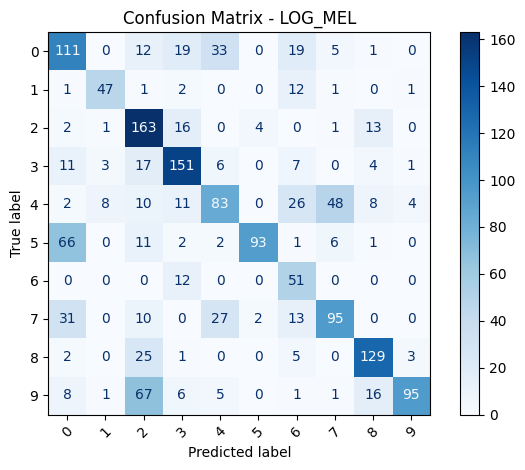

In [26]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("FINAL TEST RESULTS FOR EACH FEATURE SET")
print("=" * 60)

for feature_name, result in results.items():
    print(f"\nFeature Set: {feature_name.upper()}")

    best_model = result['best_model']
    test_loader = result['test_loader']
    best_config = result['best_config']

    if best_model is None or test_loader is None:
        print("No model or test loader found. Skipping...")
        continue

    # Evaluate on test set
    test_acc, test_preds, test_labels = evaluate(best_model, test_loader)
    f1 = f1_score(test_labels, test_preds, average="macro")

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print("Best Hyperparameter Configuration:")
    for key, value in best_config.items():
        print(f"{key:<20}: {value}")

    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {feature_name.upper()}")
    plt.tight_layout()
    plt.show()